# Results update
Sandbox for result presentation. Initialize every set of blocks with date. 

In [ ]:
################ ONLY PYTHON 2 #########################
from __future__ import division
from __future__ import print_function
from operator import itemgetter
from itertools import combinations, chain, product
from collections import defaultdict
import argparse
import time
import os
import tensorflow as tf
import numpy as np
import networkx as nx
import scipy.sparse as sp
from sklearn import metrics
import pandas as pd
import psutil
import pickle
from decagon.deep.optimizer import DecagonOptimizer
from decagon.deep.model import DecagonModel
from decagon.deep.minibatch import EdgeMinibatchIterator
from decagon.utility import rank_metrics, preprocessing

In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import time
import os
import psutil
import pickle
from pybdm import BDM
from pybdm.utils import decompose_dataset
from pybdm.partitions import PartitionIgnore
from pybdm.partitions import PartitionRecursive
from joblib import Parallel, delayed
from joblib import parallel_backend
from data.algorithms import PerturbationExperiment, NodePerturbationExperiment
import math
import datetime as dt
from itertools import product

In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/juan/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# 24/09/20

### 1. Results of reducing the network using BDM fraction=0.25
![results](chopping_big.png)
When this finishes, I wil start to train a new network with this dataset.

### 2. Exploring BDM vectors to make them sparse
Plotting BDM vectors of some networks with their histogram and their 'S' (sorted) shape.<br>
Ideas to select a threshold:
+ Take the derivative of the sorted array and normalize it. Filter it with a low-pass filter so that the data gets smooth. Select a general positive value and a general negative value, where the derivatives starts increasing drastically, identify the value when this happens and get the thresold.
+ Normalize the sorted values and find a threshold<br>

I am questioning the biological relevance and the practical contribution of adding edges to calculate BDM change, because in practice we are generating interactions of proteins that will never interact, and because this addition almost always increases the complexity of the network, we have no negative nodes. Tis could be a source of noise.

In [17]:
with open('data/data_structures/BDM/PPI_BDM_real_genes_19081_juadia64','rb') as f:
    DS = pickle.load(f)
    for key in DS.keys():
        globals()[key]=DS[key]
        print(key,"Imported successfully")

nodebdm_ppi Imported successfully
add_edgebdm_ppi Imported successfully
rem_edgebdm_ppi Imported successfully
vms_ppi Imported successfully
rss_ppi Imported successfully
time_ppi Imported successfully
jobs_ppi Imported successfully


In [19]:
sim_nodes = nodebdm_ppi
srt_nodes = np.sort(sim_nodes)
sim_add = add_edgebdm_ppi
srt_add = np.sort(sim_add)
sim_rem = rem_edgebdm_ppi
srt_rem = np.sort(sim_rem)

In [20]:
# Numerical differentiation
x = np.arange(len(sim_nodes))
dy_nodes = np.zeros(srt_nodes.shape,np.float)
dy_nodes[0:-1] = np.diff(srt_nodes)/np.diff(x)
dy_nodes[-1] = (srt_nodes[-1] - srt_nodes[-2])/(x[-1] - x[-2])
dy_nodes = dy_nodes/np.linalg.norm(dy_nodes)
dy_add = np.zeros(srt_add.shape,np.float)
dy_add[0:-1] = np.diff(srt_nodes)/np.diff(x)
dy_add[-1] = (srt_add[-1] - srt_add[-2])/(x[-1] - x[-2])
dy_add = dy_add/np.linalg.norm(dy_add)
dy_rem = np.zeros(srt_rem.shape,np.float)
dy_rem[0:-1] = np.diff(srt_rem)/np.diff(x)
dy_rem[-1] = (srt_rem[-1] - srt_rem[-2])/(x[-1] - x[-2])
dy_rem = dy_rem/np.linalg.norm(dy_rem)

In [21]:
# Discrete convolution of derivative
win = 50
v = (1/win)*np.ones(win)
conv_dy_nodes = np.convolve(dy_nodes,v,mode='same')
conv_dy_add = np.convolve(dy_add,v,mode='same')
conv_dy_rem = np.convolve(dy_rem,v,mode='same')

Text(0.5, 1.0, 'Node BDM')

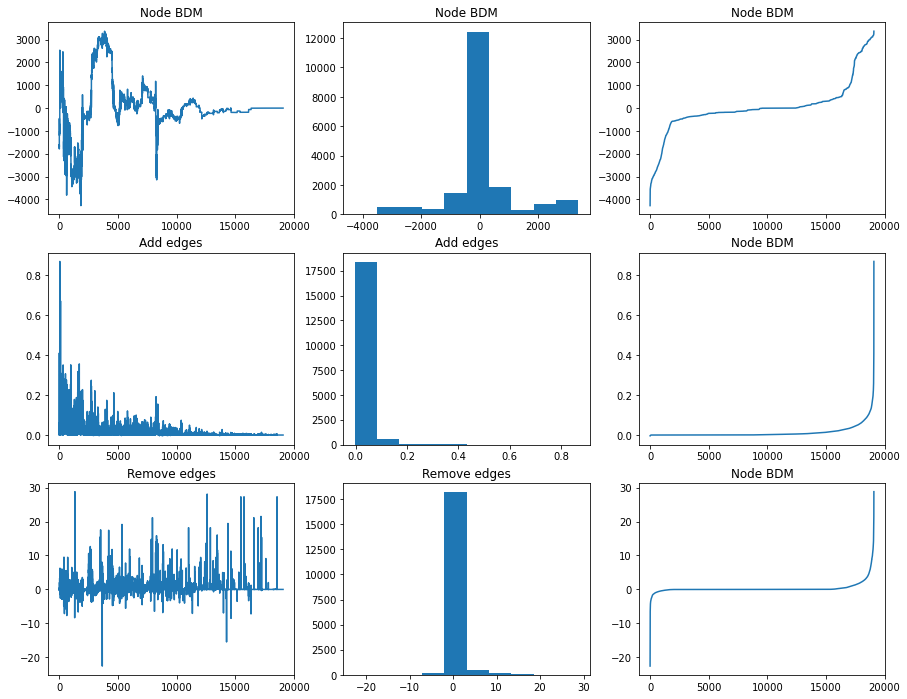

In [27]:
figure(figsize=[15,12])
subplot(3,3,1)
plot(sim_nodes)
title('Node BDM')
subplot(3,3,2)
hist(sim_nodes)
title('Node BDM')
subplot(3,3,3)
plot(srt_nodes)
#plot(dy_nodes)
#plot(conv_dy_nodes)
title('Node BDM')
subplot(3,3,4)
plot(sim_add)
title('Add edges')
subplot(3,3,5)
hist(sim_add)
title('Add edges')
subplot(3,3,6)
plot(srt_add)
#plot(dy_add)
#plot(conv_dy_add)
title('Node BDM')
subplot(3,3,7)
plot(sim_rem)
title('Remove edges')
subplot(3,3,8)
hist(sim_rem)
title('Remove edges')
subplot(3,3,9)
plot(srt_rem)
#plot(dy_rem)
#plot(conv_dy_rem)
title('Node BDM')

In [28]:
down_threshold = -500
up_threshold = 500

In [29]:
neg = sim_nodes<down_threshold
pos = sim_nodes>up_threshold

In [30]:
bin_nodebdm_ppi = neg.astype(int)*-1+pos.astype(int)

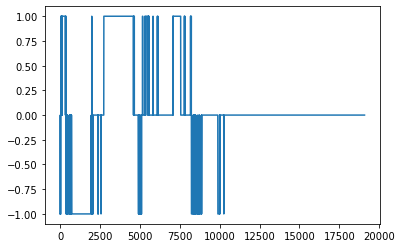

In [31]:
plot(bin_nodebdm_ppi)

Next: couple scripts and start training with new BDM vector

### 3. Software note
1. More control over batches?
2. Public dataset?
3. Code as it is? no further improvements? Just reproductibility?. Duplicates of matrices?

### 4. Comments on Validation phase
1. Have been considering skipping the experiments consisting on adding columns of zeros in the DTI adjacency matrix, to simulate a testing dataset with 'new' drugs. The reason for this is that this will affect the creation of the embedding vectors in the inner layers of the encoder. The embeddings for these drugs would not incorporate the DTI information, so no comunucation with the gene dataset. This would be the equivalent of trying to predict the side effect only with the drug side effects.
2. TWOSIDES translation of drug names
3. True negative interactions vs. unknowns: I think that the search for such a dataset would be very time consuming and not contribute in big extend to an increase of the performance of the model, but more into the applicability in real-life situations. I think it is better to add that idea in the conclusions and 'limitations' of the model.
4. Mouse PPI

### 5. Cluster GCN....

### 6. Mouse PPI
### Affinities